In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
from scipy import spatial

/home/tim/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<b>Opening data</b>

In [2]:
# 574 entries (photos)
data = pd.read_excel('complete_dataset.xlsx')
data.head()

,PhotoID,Photopath,studentID,Theme,Tags[..],Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,8,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,no person 0.99,still life 0.99,food 0.95,indoors 0.95,sculpture 0.95,grow 0.94,...,light 0.90,table 0.88,interior design 0.87,toy 0.87,flower 0.86,wood 0.86,one 0.85,vase 0.85,furniture 0.83,portrait 0.82
1,4,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,access 1.00,metal key 1.00,lock 1.00,security 1.00,padlock 1.00,unlock 0.99,...,steel 0.97,still life 0.97,jewelry band 0.96,no person 0.96,cutout 0.95,admittance 0.95,door 0.95,keyhole 0.95,one 0.93,chain 0.93
2,6,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,tree 0.99,park 0.98,cemetery 0.97,no person 0.97,fall 0.97,step 0.96,...,bench 0.95,landscape 0.95,wood 0.94,nature 0.93,road 0.93,street 0.92,outdoors 0.91,winter 0.91,leaf 0.91,light 0.91
3,5,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,ball-shaped 0.99,no person 0.99,geography 0.99,planet 0.97,travel 0.97,map 0.97,...,art 0.93,one 0.93,sphere 0.93,round out 0.92,retro 0.90,universe 0.89,cartography 0.88,wood 0.88,traditional 0.87,ancient 0.86
4,7,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,time 1.00,clock 1.00,watch 1.00,precision 0.99,analogue 0.99,wrist 0.99,...,watch over 0.97,timer 0.97,noon 0.97,timepiece 0.96,early 0.96,pressure 0.95,quartz 0.94,dial 0.94,analog 0.93,countdown 0.92


<b>TF-IDF metric on tags</b>
<br>
Collecting the term frequency within a theme

In [3]:
# Return the term frequency matrix for a given theme
# Amount of photo's in a theme that use this tag
def term_frequency_matrix(subset):
    tags = subset.iloc[:, 4:,]
    all_cols = [col for col in tags]
    # Get all unique tags in this theme
    temp = pd.unique(tags[all_cols].values.ravel())
    unique_tags = []
    for tag in temp:
        tag = ' '.join(tag.split(' ')[:-1])
        unique_tags.append(tag)
     
    matrix = []
    unique_tags = set(unique_tags)
    total_nr_tags = len(unique_tags)
    for tag in unique_tags:
        # Check for every tag how many times the tag appears in a column (for this theme)
        term_freq = 0
        for col in tags:
            for t in subset[col]:
                x = ' '.join(t.split(' ')[:-1])
                if x == tag:
                    term_freq += 1
        matrix.append([tag, term_freq])
    matrix.sort(key=lambda x:x[1], reverse=True)
    return np.array(matrix)


In [4]:
anger_set = data.loc[data['Theme'] == 'anger']
network_set = data.loc[data['Theme'] == 'network']
student_well_being_set = data.loc[data['Theme'] == 'student_well_being']
impuls_set = data.loc[data['Theme'] == 'impuls']
climate_change_set = data.loc[data['Theme'] == 'climate_change']
garbage_non_existent_set = data.loc[data['Theme'] == 'garbage_non_existent']
tf_dict = {'anger':term_frequency_matrix(anger_set),
          'network':term_frequency_matrix(network_set),
          'student_well_being':term_frequency_matrix(student_well_being_set),
          'impuls':term_frequency_matrix(impuls_set),
          'climate_change':term_frequency_matrix(climate_change_set),
          'garbage_non_existent':term_frequency_matrix(garbage_non_existent_set)}

In [5]:
print(tf_dict['climate_change'])


[['no person' '69']
 ['family' '27']
 ['street' '27']
 ...
 ['stopper' '1']
 ['desk' '1']
 ['ash' '1']]


<b>Calculating the tf-idf score of a tag</b>
<br>
tf = term frequency of a tag within a class / total amount of unique tags within a class
<br>
idf = total number of photos / total frequency of a tag in the entire data
<br>
tf-idf = tf * idf

In [6]:
# Return the idf, the frequency of a given tag in all photos divided by
# the frequency of the tag in this class
# Total number of photos: 574
def get_idf(tf_dict, tag):
    total_freq = 0
    for theme in tf_dict.keys():
        for t in tf_dict[theme]:
            if t[0] == tag:
                total_freq += int(t[1])
    return np.log(np.divide(574, total_freq))

# Return the total amount of unique tags in data
def all_unique_tags(tf_dict):
    tags = []
    for theme in tf_dict.keys():
        for t in tf_dict[theme]:
            tags.append(t[0])
    return len(set(tags))

# Term frequency x inverse document frequency
def tf_idf(tf_dict):
    tf_idf_dict = {}
    for theme in tf_dict.keys():
        total_number_tags = len(tf_dict[theme])
        temp = []
        for i,tag in enumerate(tf_dict[theme][:,0]):
            # tf = term frequency of tag in class / number of tags in this class
            tf = np.divide(int(tf_dict[theme][i][1]), total_number_tags)
            idf = get_idf(tf_dict, tag)
            score = np.multiply(tf,idf)
            temp.append([tag, score])
        temp.sort(key=lambda x:x[1], reverse=True)
        tf_idf_dict[theme] = np.array(temp)
    return tf_idf_dict 

tf_idf_scores = tf_idf(tf_dict)

We now have a dictionary of all unique tags per theme. The tags are sorted on their tf-idf score.

In [7]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(tf_idf_scores['climate_change'][:50])

[['outdoors' '0.07303570252665945']
 ['nature' '0.07045536746579582']
 ['industry' '0.06755384335905575']
 ['landscape' '0.06752345660852165']
 ['street' '0.06737685290136328']
 ['sky' '0.06527555171975356']
 ['urban' '0.06512724586051645']
 ['city' '0.06400155219073946']
 ['family' '0.06341261009931451']
 ['summer' '0.06145437360636113']
 ['plastic' '0.06084719950717187']
 ['recycling' '0.05808375973816905']
 ['vehicle' '0.05705350844236911']
 ['technology' '0.056668777110841256']
 ['light' '0.055166940288192926']
 ['container' '0.0547032466923939']
 ['color' '0.05064259245639123']
 ['park' '0.05061083187353665']
 ['indoors' '0.05016510414656069']
 ['still life' '0.050085595108867044']
 ['transportation system' '0.050085595108867044']
 ['leaf' '0.05005108728580662']
 ['H2O' '0.0492606553340424']
 ['road' '0.04882266835088118']
 ['tree' '0.04872877365005871']
 ['architecture' '0.04817739306003387']
 ['car' '0.04786873792781928']
 ['sun' '0.04775527777135727']
 ['steel' '0.0470615728267

<b>Measuring semantic similarity</b>
<br>
Using a pretrained model of word2vec from google containing word vectors for 3 million words and phrases:<br>
"https://code.google.com/archive/p/word2vec/"
<br>
Setting the limit to 1.500.000

In [8]:
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True, limit=1500000)

In [9]:
# Outlier detection
# def remove_outlier(vector_row):
#     delete_list = []
#     sim_score = []
#     for v1 in vector_row:
#         temp = []
#         for v2 in vector_row:
#             cosine_similarity = 1 - spatial.distance.cosine(v1, v2)
#             temp.append(cosine_similarity)
#         sim_score.append(sum(temp)/len(temp))
#     sim_score = np.array(sim_score)
#     mean = np.mean(sim_score)
#     sd = np.std(sim_score)
#     for i,score in enumerate(sim_score):
#         if score < mean - 2 * sd:
#             delete_list.append(i)
#         if score > mean + 2 * sd:
#             delete_list.append(i)
#     return np.delete(vector_row,delete_list, axis=0)

# Get the sum vector for a photo based on 20 tags.
# The sum vector is taken by summing up all word vectors

def get_sum_vector(row, theme, model):
    row_vector = np.zeros((300, ))
    total_words = 0
    tag_list = []
    for cell in row[4:]:
        tag = ' '.join(cell.split(' ')[:-1])
        # Ignore 'no person'
        if tag ==  'no person':
            continue
        tag = tag.split()[-1]
        # Remove brackets
        if tag[0] == '(':
            tag = tag.strip("()")
        try:
            row_vector = np.add(row_vector, model[tag])
            tag_list.append(tag)
        except KeyError:
            pass
        
    #row_vector = remove_outlier(row_vector)
    
    # Mean of Word Embeddings
    for i,tag in enumerate(tag_list):
        for t,v in tf_idf_scores[theme]:
            if t == tag:
                row_vector[i] = row_vector[i] * float(v)
                break
 
    # L1 normalized sum of word vectors
    normalized_row_vector = row_vector / np.linalg.norm(row_vector)
    
    return list(row_vector)

# Kmeans
def get_clusters(all_vectors, k):
    clustering_model = KMeans(n_clusters=k)
    return clustering_model.fit_predict(all_vectors)

# Elbow method to determine optimal k
def find_optimal_k(all_vectors):
    n_clust = range(1, 20)
    sqd = []
    for k in n_clust:
        clustering_model = KMeans(n_clusters=k)
        clustering_model.fit(all_vectors)
        sqd.append(clustering_model.inertia_)
    plt.plot(n_clust, sqd)
    plt.show()

# Combine vectors of all photo's into an array
def construct_vector_set(subset):
    all_vectors = []
    for i, row in enumerate(subset):
        vector = get_sum_vector(row, theme, model)
        all_vectors.append(vector)
    all_vectors = np.array(all_vectors)
    return all_vectors

# Plot the pca of the word2vec vectors
def plot_semantic_similarity(theme, similarity_vectors,model, subset, n_clust):
    
    # Transform data to 2-dimensional
    #pca_data = PCA(n_components=2).fit_transform(similarity_vectors)
    pca = PCA(n_components=2, random_state=0)
    pca_data = pca.fit_transform(similarity_vectors)    
    
    # Get cluster labels
    clusters = get_clusters(pca_data, n_clust)
    
    fig, ax = plt.subplots()
    color_map = {
        0: 'blue', 1: 'green', 2: 'red', 
        3: 'black', 4: 'yellow', 5: 'purple',
        6: 'lightblue', 7: 'orange', 8: 'grey', 
    }
    #print(subset[0])
    for i, instance in enumerate(pca_data):
        x, y = pca_data[i]
        ax.scatter(x, y, color = color_map[clusters[i]])
        if subset[:,0][i] in [68,411,121]: 
            ax.annotate(subset[:,0][i], xy=(x, y))
        ax.set_title("Semantic similarity in the theme: " + "'" + theme + "'")
    ax.set
    plt.show()
    result = np.c_[subset, clusters]
    # Return data of this theme with respective cluster label
    return result


Elbow method for: student_well_being


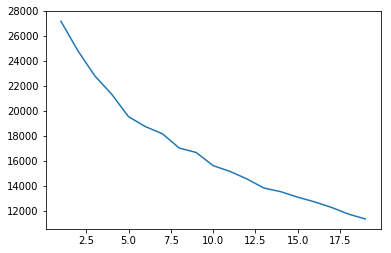

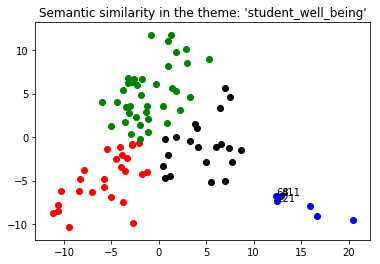

Elbow method for: network


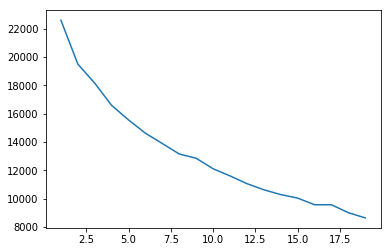

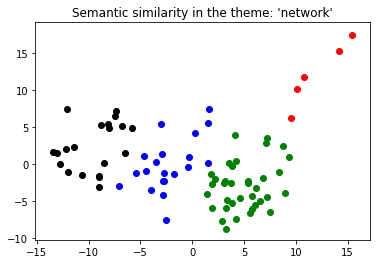

Elbow method for: climate_change


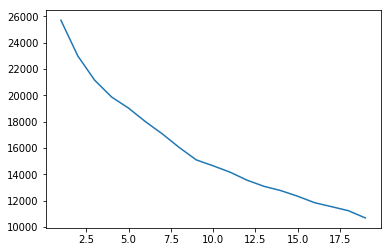

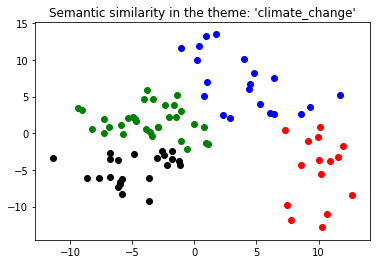

Elbow method for: anger


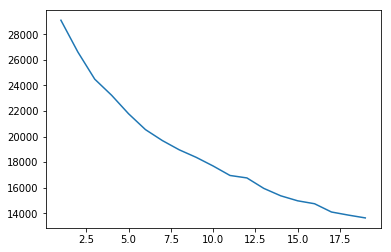

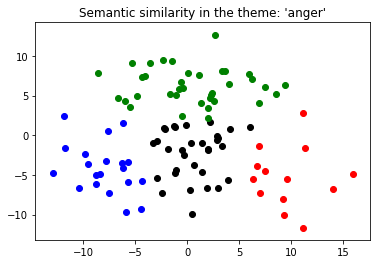

Elbow method for: impuls


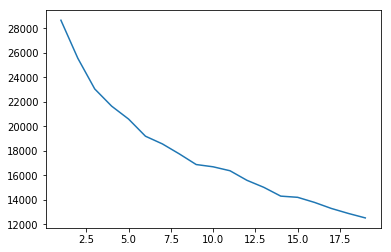

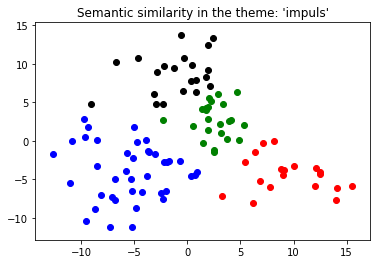

Elbow method for: garbage_non_existent


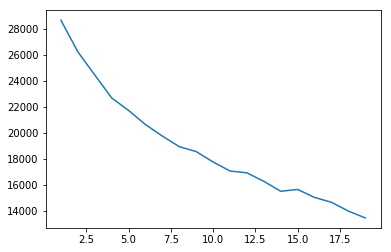

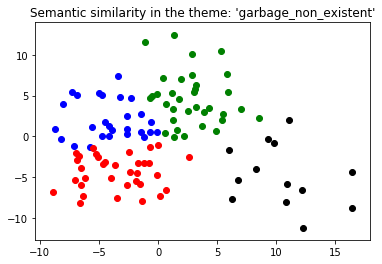

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


themes = data.Theme.unique()
clusters = {}
for theme in themes:
    subset = data.loc[data['Theme'] == theme]
    subset = subset.to_numpy()
    similarity_vectors = construct_vector_set(subset)
    print("Elbow method for: " + theme)
    find_optimal_k(similarity_vectors)
    clust = plot_semantic_similarity(theme, 
                                 similarity_vectors, 
                                 model,
                                 subset,
                                 4)
    clust_sort = sorted(zip(clust[:,0], clust[:,-1]), key = lambda x: x[1])
    clusters[theme] = clust_sort

<b> View clusters of photos by copying them in a new cluster directory</b>

In [11]:
import os.path
from os import path
import glob
from shutil import copyfile
import shutil

In [12]:

if path.exists('/home/tim/Documents/scriptie/clusters'):
    shutil.rmtree('/home/tim/Documents/scriptie/clusters')
os.mkdir('/home/tim/Documents/scriptie/clusters')

In [13]:



# for theme in themes:
#     subset = data.loc[data['Theme'] == theme]
#     subset_array = subset.to_numpy()
#     path = '/home/tim/Documents/scriptie/clusters/'+str(theme)
#     os.mkdir(path)
#     os.mkdir(path + '/0')
#     os.mkdir(path + '/1')
#     os.mkdir(path + '/2')
#     for row in subset_array:
#         for photoid, label in clusters[theme]:
#             if row[0] == photoid:
#                 src = row[1]
#                 if label == 0:  
#                     dst = path +'/0'
#                 if label == 1:  
#                     dst = path +'/1'
#                 if label == 2:  
#                     dst = path +'/2'
#                 shutil.copy2(src, dst)
        

<b>Topic modelling</b>
<br>
Generate the most relevant tags in a cluster
by multiplying the term frequency of a tag in a cluster with the tf-idf score of that tag.

In [14]:
cols = data.columns
print(cols)
clus_0, clus_1, clus_2, clus_3 = [], [], [], []

Index(['PhotoID', 'Photopath', 'studentID', 'Theme', 'Tags[..]', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')


In [28]:
themes = ['anger', 'student_well_being', 'network', 'climate_change', 'impuls', 'garbage_non_existent']
cols = data.columns
top_keywords = {}
for theme in themes:
    subset = data.loc[data['Theme'] == theme]
    subset_array = subset.to_numpy()
    clus_0, clus_1, clus_2, clus_3 = [], [], [], []
    for row in subset_array:
        for photoid, label in clusters[theme]:
            if row[0] == photoid:
                if label == 0:
                    clus_0.append(row)
                if label == 1:  
                    clus_1.append(row)
                if label == 2:  
                    clus_2.append(row) 
                if label == 3:
                    clus_3.append(row)
    clus_0 = pd.DataFrame(np.array(clus_0), columns = [cols])
    clus_1 = pd.DataFrame(np.array(clus_1), columns = [cols])
    clus_2 = pd.DataFrame(np.array(clus_2), columns = [cols])
    clus_3 = pd.DataFrame(np.array(clus_3), columns = [cols])

    clus_0 = term_frequency_matrix(clus_0)
    clus_1 = term_frequency_matrix(clus_1)
    clus_2 = term_frequency_matrix(clus_2)
    clus_3 = term_frequency_matrix(clus_3)

    c = [clus_0, clus_1, clus_2, clus_3]
    labels = ['clus_0', 'clus_1', 'clus_2', 'clus_3'] 
    tmp = {}

    for i, label in enumerate(labels):
        tmp[label] = c[i] 
    top_keywords[theme] = tf_idf(tmp)
    #print(c)
#     for cc in c:
#         for i, tf in enumerate(cc):
#             print(i,tf)
#             theme = subset.iloc[1]['Theme']
#             for tag, score in tf_idf_scores[theme]:
#                 if tf[0] == tag:
#                     cc[i][1] = (int(tf[1])/len(cc)) * float(score)
#                 # ignore no person
#                 if tf[0] == 'no person':
#                     cc[i][1] = 0
#     c[0] = clus_0[clus_0[:, 1].argsort()][::-1]
#     c[1] = clus_1[clus_1[:, 1].argsort()][::-1]
#     c[2] = clus_2[clus_2[:, 1].argsort()][::-1]
#     c[3] = clus_3[clus_3[:, 1].argsort()][::-1]
    #top_keywords[theme] = c

In [32]:

print(top_keywords['anger'])

{'clus_0': array([['business', '0.2745518332511879'],
       ['illustration', '0.21643885936331597'],
       ['design', '0.20826166829813464'],
       ['no person', '0.20721753571107895'],
       ['internet', '0.19534573049781626'],
       ['World Wide Web', '0.17626876989057014'],
       ['vector', '0.17626876989057014'],
       ['facts', '0.17626876989057014'],
       ['education', '0.17092751418558924'],
       ['paper', '0.16365900224364732'],
       ['desktop', '0.15580299049842863'],
       ['symbol', '0.15108751704906012'],
       ['text', '0.15108751704906012'],
       ['graphic design', '0.15108751704906012'],
       ['sign', '0.13031056934547175'],
       ['technology', '0.12732247085843343'],
       ['electronics', '0.11571555152358631'],
       ['flat', '0.1135162293759926'],
       ['vectors', '0.1135162293759926'],
       ['navigation', '0.1135162293759926'],
       ['image', '0.1135162293759926'],
       ['information', '0.10841580534595352'],
       ['data', '0.10841580

<b>Create excel file with keywords of every cluster in a theme</b>

In [34]:
import xlsxwriter
themes = data.Theme.unique()

for theme in top_keywords.keys():
    column = 0
    name = 'keywords_' + str(theme) + '.xlsx'
    workbook = xlsxwriter.Workbook(name)
    worksheet = workbook.add_worksheet()
    for i,cluster in enumerate(top_keywords[theme].values()):
        row = 0
        worksheet.write(row, column, "Cluster_" + str(i) + '_tag')
        worksheet.write(row, column+1, "Cluster_" + str(i) + '_score')
        row += 1
        for tag, score in cluster:
            worksheet.write(row, column, tag)
            worksheet.write(row, column + 1, score)
            row += 1
        column +=2
    workbook.close()

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0